<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import modules</a></span></li><li><span><a href="#Recommender-system-and-collaborative-filtering" data-toc-modified-id="Recommender-system-and-collaborative-filtering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Recommender system and collaborative filtering</a></span></li><li><span><a href="#Import-dataset" data-toc-modified-id="Import-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Import dataset</a></span></li><li><span><a href="#User-to-rate-matrix" data-toc-modified-id="User-to-rate-matrix-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>User to rate matrix</a></span></li><li><span><a href="#Split-the-data" data-toc-modified-id="Split-the-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Split the data</a></span></li><li><span><a href="#Matrix-Factorization" data-toc-modified-id="Matrix-Factorization-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Matrix Factorization</a></span></li><li><span><a href="#Alternating-Least-Squares-with-Weighted-Regularization-(ALS-WR)" data-toc-modified-id="Alternating-Least-Squares-with-Weighted-Regularization-(ALS-WR)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Alternating Least Squares with Weighted Regularization (ALS-WR)</a></span></li><li><span><a href="#References" data-toc-modified-id="References-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** Alternating Least Squares with Weighted Regularization

</font>
</div>

# Import modules
<hr style = "border:2px solid black" ></hr>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from subprocess import call
from sklearn.metrics import mean_squared_error

# Recommender system and collaborative filtering
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- Recommendation system is a popular topic in recent years, what is does (or its goal) is to seek to predict the "rating" or "preference" that a user would give to an item. Given the rating, the business will then recommend preferable new items to the user for further purchases. 

- The type of recommendation system that we will be discussing is known as **collaborative filtering**, where the features of the user (e.g. age, gender) or the item (e.g. perishable or not) itself do not play any role in the algorithm. Instead, we rely solely on the ratings that a user gave to the item.
    
</font>
</div>

# Import dataset
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- We start by loading some sample data to make this a bit more concrete. For this introduction, we'll be using the [MovieLens dataset](http://grouplens.org/datasets/movielens/). 
- The website has datasets of various sizes, but we just start with the smallest one [MovieLens 100K Dataset](http://files.grouplens.org/datasets/movielens/ml-100k.zip). 
- This dataset consists of 100,000 movie ratings by users (on a 1-5 scale). 
- The main data set `u.data` file consists of four columns (tab-delimited), including user-id (starting at 1), item-id (starting at 1), rating, and timestamp (we won't be using this field).

</font>
</div>

In [3]:
# download the dataset if it isn't in the same folder
file_dir = 'ml-100k'
file_path = os.path.join(file_dir, 'u.data')
if not os.path.isdir(file_dir):
    call(['curl', '-O', 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'])
    call(['unzip', 'ml-100k.zip'])

names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(file_path, sep = '\t', names = names)
print(df.shape)
df.head()

(100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


# User to rate matrix
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- We only have data that we have is how each user interacted or rated each item. 
- Given this information, **collaborative filtering** will start by constructing a user-item matrix with each distinct user being the row, item being the column and the value for each cell will simply be the rating that the user gave to the item. 
- Apart from building the matrix, we will also print out some other information to help us understand our data a bit better.

</font>
</div>

In [4]:
# create the rating matrix r_{ui}, remember to
# subract the user and item id by 1 since
# the indices starts from 0
n_users = df['user_id'].unique().shape[0]
n_items = df['item_id'].unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples(index=False):
    ratings[row.user_id - 1, row.item_id - 1] = row.rating

# compute the non-zero elements in the rating matrix
matrix_size = np.prod(ratings.shape)
interaction = np.flatnonzero(ratings).shape[0]
sparsity = 100 * (interaction / matrix_size)

print('dimension: ', ratings.shape)
print('sparsity: {:.1f}%'.format(sparsity))
ratings

dimension:  (943, 1682)
sparsity: 6.3%


array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

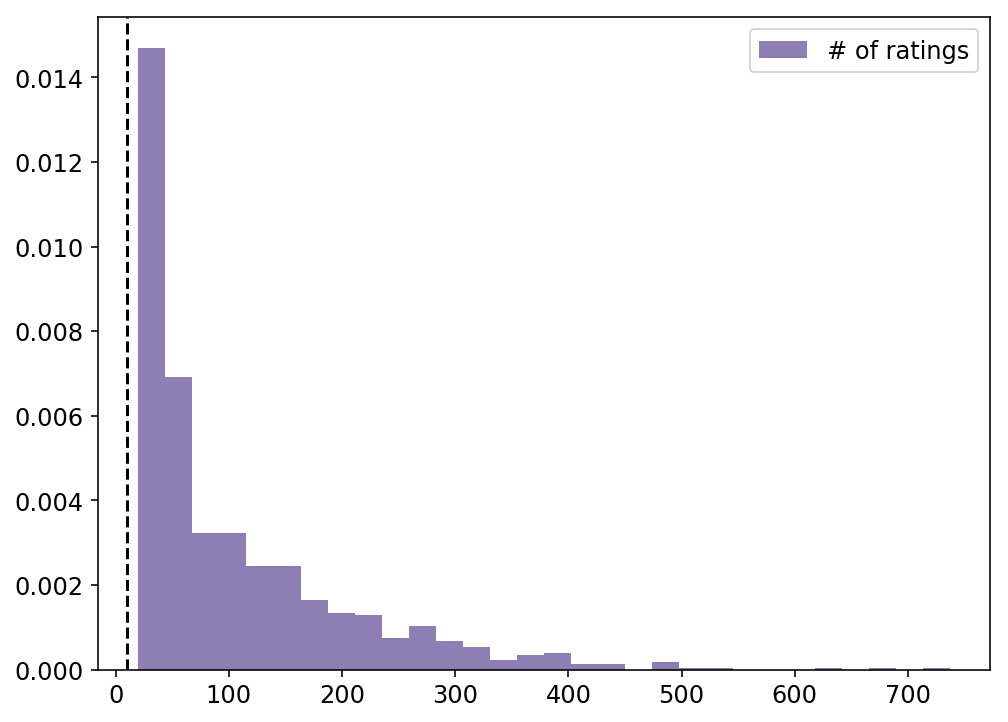

In [5]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

plt.hist(np.sum(ratings != 0, axis = 1), histtype = 'stepfilled', bins = 30,
         alpha = 0.85, label = '# of ratings', color = '#7A68A6', normed = True)
plt.axvline(x = 10, color = 'black', linestyle = '--')
plt.legend(loc = "upper right")
plt.show()

<div class="alert alert-info">
<font color=black>

- From the information above, we know there are 943 unique users, 1682 unique items. Within the rating matrix, only 6.3% of the cells have a value, although we filled in empty ratings as 0, we should not assume these values to truly be zero. More appropriately, they are just missing entries. 
    
- This kind of sparsity is **extremely common** in recommendation system, where people seldom give ratings to things that they have purchased. One thing to note is that if the sparsity of the matrix is below 1% (rule of thumb), then the dataset might be too sparse to perform any sort of modeling.

- Next the histogram tells us that every user has given at least more than 10 ratings, we will use this to perform the train/test split of the data for testing the algorithm that we'll build later.

</font>
</div>

# Split the data
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- For recommender systems with collaborative filtering (no features), a simple random train/test split won't work anymore, because all of the items/users need to be available when the model is first built. 
    
- So what we do instead is mask a random sample of the user/item ratings to validate and compare how well the recommender system did in predicting the ratings of those masked values. 
    
- In our case, given we already know each user has given more than 10 ratings, what we'll do is for every user, we remove 10 of the item ratings and and assign them to the test set. 
    
</font>
</div>

In [ ]:
def create_train_test(ratings):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(ratings[user]), size=10, replace=False)

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]

    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test


train, test = create_train_test(ratings)
del ratings
train

# Matrix Factorization
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- Recall that we had a user-item matrix, $R$ where nonzero elements of the matrix are ratings that a user has given an item. 

- What Matrix Factorization does is it decomposes a large matrix into products of matrices, namely, $R = U \times V$. 

- Matrix factorization assumes that:
    - Each user can be described by $d$ features. For example, feature 1 might be a referring to how much each user likes disney movies.
    - Each item, movie in this case, can be described by an analogous set of $d$ features. To correspond to the above example, feature 1 for the movie might be a number that says how close the movie is to a disney movie.

- After learning the two smaller matrices, all we have to do is to perform a matrix multiplication of the two matrices and the end result will be a our approximation for the rating the user would give that item (movie).

- The interesting thing about this is that, we do not know what these features are nor do we have to determine them beforehand, which is why these features are often refer to as latent features. Next, we also don't know how many latent features are optimal for the task at hand. Thus, we can use random search or grid search or other fancy techniques to perform hyperparameter tuning and determine the best number for $d$. 

- Given all those information, the next question is: how do we learn the user matrix, $U$, and item matrix, $V$? Like a lot of ML algorithms, by minimising a loss function.

</font>
</div>

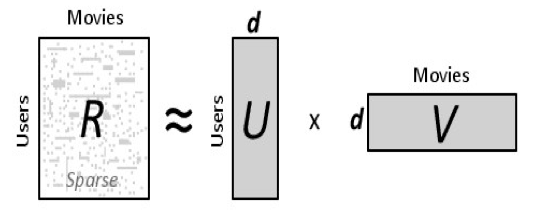

Now that the data preprocessing part has been taken care of, let's get to the more exciting part, the algorithm. The algorithm that we'll introduce today is Matrix Factorization.

Recall that we had a user-item matrix, $R$ where nonzero elements of the matri

We start by denoting our $d$ feature user into math by letting a user $u$ take the form of a $1 \times d$-dimensional vector $\textbf{x}_{u}$. These for often times referred to as latent vectors or low-dimensional embeddings. Similarly, an item *i* can be represented by a $1 \times d$-dimensional vector $\textbf{y}_{i}$. And the rating that we predict user $u$ will give for item $i$ is just the dot product of the two vectors

$$
\begin{align}
\hat r_{ui} &= \textbf{x}_{u} \textbf{y}_{i}^{T} = \sum\limits_{d} x_{ud}y_{di}
\end{align}
$$

Where $\hat r_{ui}$ represents our prediction for the true rating $r_{ui}$. Next, we will choose a objective function to minimize the square of the difference between all ratings in our dataset ($S$) and our predictions. This produces a objective function of the form:

$$
\begin{align}
L &= \sum\limits_{u,i \in S}( r_{ui} - \textbf{x}_{u} \textbf{y}_{i}^{T} )^{2} + \lambda \big( \sum\limits_{u} \left\Vert \textbf{x}_{u} \right\Vert^{2} + \sum\limits_{i} \left\Vert \textbf{y}_{i} \right\Vert^{2} \big)
\end{align}
$$

Note that we've added on two $L_{2}$ regularization terms, with $\lambda$ controlling the strength at the end to prevent overfitting of the user and item vectors. $\lambda$, is another hyperparameter that we'll have to search for to determine the best value. 

# Alternating Least Squares with Weighted Regularization (ALS-WR)
<hr style = "border:2px solid black" ></hr>

Now that we formalize our objective function, we'll introduce the **Alternating Least Squares with Weighted Regularization (ALS-WR)** method for optimizing it. The way it works is we start by treating one set of latent vectors as constant. For this example, we'll pick the item vectors, $\textbf{y}_{i}$. We then take the derivative of the loss function with respect to the other set of vectors, the user vectors, $\textbf{x}_{u}$ and solve for the non-constant vectors (the user vectors).

$$
\begin{align}
\frac{\partial L}{\partial \textbf{x}_{u}} 
&= - 2 \sum\limits_{i}(r_{ui} - \textbf{x}_{u} \textbf{y}_{i}^{T} ) \textbf{y}_{i} + 2 \lambda \textbf{x}_{u} = 0 \\
&= -(\textbf{r}_{u} - \textbf{x}_{u} Y^{T} )Y + \lambda \textbf{x}_{u} = 0 \\
&= \textbf{x}_{u} (Y^{T}Y + \lambda I) = \textbf{r}_{u}Y \\
&= \textbf{x}_{u} = \textbf{r}_{u}Y (Y^{T}Y + \lambda I)^{-1}
\end{align}
$$

To clarify it a bit, let us assume that we have $m$ users and $n$ items, so our ratings matrix is $m \times n$.

- The row vector $\textbf{r}_{u}$ represents users *u*'s row from the ratings matrix with all the ratings for all the items (so it has dimension $1 \times n$)
-  We introduce the symbol $Y$, with dimensions $n \times d$, to represent all item row vectors vertically stacked on each other
- Lastly, $I$ is the identity matrix which has dimension $d \times d$ to ensure the matrix multiplication's dimensionality will be correct when we add the $\lambda$

Now comes the alternating part: With these newly updated user vectors in hand, in the next round, we hold them as constant, and take the derivative of the loss function with respect to the previously constant vectors (the item vectors). As the derivation for the item vectors is quite similar, we will simply list out the end formula:

$$
\begin{align}
\frac{\partial L}{\partial \textbf{y}_{i}}
&= \textbf{y}_{i} = \textbf{r}_{i}X (X^{T}X + \lambda I)^{-1}
\end{align}
$$

Then we alternate back and forth and carry out this two-step process until convergence. The reason we alternate is, optimizing user latent vectors, $U$, and item latent vectors $V$ simultaneously is hard to solve. If we fix $U$ or $V$ and tackle one problem at a time, we potentially turn it into a easier sub-problem. Just to summarize it, ALS works by:

1. Initialize the user latent vectors, $U$, and item latent vectors $V$ with randomly
2. Fix $U$ and solve for $V$
3. Fix $V$ and solve for $U$
4. Repeat step 2 and 3 until convergence

We'll set the model to use 20 factors and a regularization value of 0.01 (chosen at random) and train it for 100 iterations and compute the mean square error on the train and test set to assess algorithm convergence.

In [7]:
class ExplicitMF:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix

    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm

    n_factors : int
        number of latent factors to use in matrix 
        factorization model, some machine-learning libraries
        denote this as rank

    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors

    def fit(self, train, test):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))

        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_mse_record = []
        self.train_mse_record = []
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(
                train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(
                train.T, self.item_factors, self.user_factors)
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)

        return self

    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs

    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred

    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse

In [8]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label='Test', linewidth=linewidth)
    plt.plot(model.train_mse_record, label='Train', linewidth=linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc='best')

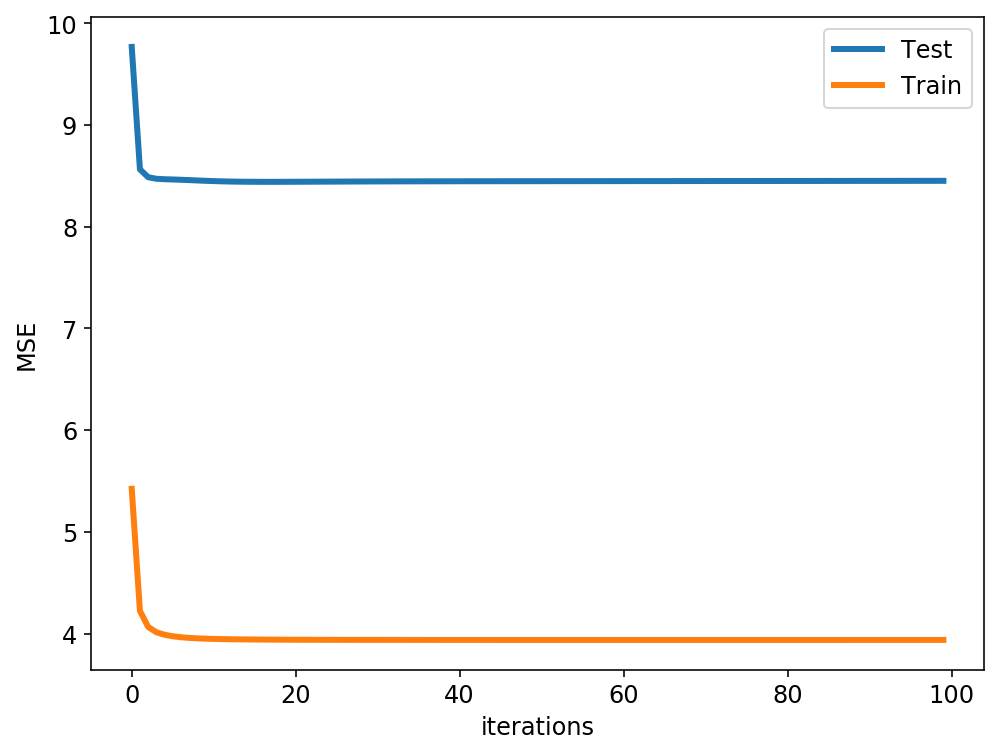

In [9]:
als = ExplicitMF(n_iters=100, n_factors=40, reg=0.01)
als.fit(train, test)
plot_learning_curve(als)

Notice that ALS converges after a few sweeps, which is one of the main reason for its popularity. Fast, thus scalable to bigger dataset.

# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- [This code notebook](https://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/recsys/1_ALSWR.ipynb)
- [Blog: Intro to Recommender Systems: Collaborative Filtering](http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/)
- [Blog: Explicit Matrix Factorization: ALS, SGD, and All That Jazz](http://blog.ethanrosenthal.com/2016/01/09/explicit-matrix-factorization-sgd-als/)
- [Quora: What is the Alternating Least Squares method in recommendation systems?](https://www.quora.com/What-is-the-Alternating-Least-Squares-method-in-recommendation-systems)

</font>
</div>